In [1]:
import time
import math
import scipy.linalg
import numpy as np
from numba import njit

from ufl import *
from dolfin import *
from mpi4py import MPI
from optimal_distribution import *

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from matplotlib import animation

from mpi_gmsfem import SpaceBlocks
from gmsfem import MsFEM
from utils import *

In [2]:
%load_ext line_profiler

In [3]:
n_el = 8
n_blocks = 4 # must be > 3
# n_el = 128
# n_blocks = 8
N_el = n_el * n_blocks
N_c = (n_blocks-1)*(n_blocks-1)
M_off = 10
M_on = 4
pairs = None

args = (n_el, n_blocks, pairs)

eta = [1e2, 1e3]
K = get_simple_kappa(eta, N_el, seed=123)
N_v = len(eta)

calc_weigths = lambda k: k.vector().get_local().sum()
weights = np.vectorize(calc_weigths, 'O')(K)
avg_K = project(np.sum(K/weights), K[0].function_space())

def get_dofs(fns):
    out = []
    for fn in fns:
        dofs = fn.compute_vertex_values()
        out.append(dofs)
    return np.array(out)

def restore_fns(vdofs, V):
    out = []
    v2d = vertex_to_dof_map(V)
    for dofs in vdofs:
        fn = Function(V)
        fn.vector()[v2d] = dofs
        out.append(fn)
    return np.array(out)

fine_mesh = UnitSquareMesh(N_el, N_el)
W = FunctionSpace(fine_mesh, 'P', 1)

mesh = UnitSquareMesh(2*n_el, 2*n_el)
mesh.scale(2./n_blocks)
V = FunctionSpace(mesh, 'P', 1)

In [4]:
np.random.seed(123)
n_strips = np.random.randint(10//3, 10)
mask = generate_mask(n_strips, N_el, 2)
rhs = 'sin(2*pi*x[0])*sin(2*pi*x[1])'

In [5]:
ms_solver = MsFEM(n_el, n_blocks, mask, rhs, pi=math.pi)
ms_solver.buildSnapshotSpace()

In [ ]:
ms_solver.buildOfflineSpace()

In [6]:
def buildOfflineSpace():
    build = np.vectorize(assemble, [float])
    psi_ms = []
    for kappa, U, DU  in zip(ms_solver._kappa, ms_solver._U, ms_solver._DU):
        # >> mass matrix
        A = build(kappa * np.outer(U, U) * dx)
        # >> stiffness matrix
        S = build(kappa * np.tensordot(DU, DU, [1, 1]) * dx)

        N = len(A)
        w, v = scipy.linalg.eigh(A, S, eigvals=(N-ms_solver.M_off,N-1))
        psi_ms.append(np.dot(U, v))

In [9]:
%lprun -f buildOfflineSpace buildOfflineSpace()

In [20]:
psi = np.array(ms_solver._U[0])
kappa = ms_solver._kappa[0]

In [21]:
build = np.vectorize(assemble, [float])
form = np.vectorize(
    lambda u, v: assemble(kappa*dot(grad(u),grad(v))*dx), [float])

In [25]:
%time A = build(kappa*np.outer(psi, psi)*dx).shape

CPU times: user 0 ns, sys: 3.67 ms, total: 3.67 ms
Wall time: 3.21 ms


In [22]:
%time form(psi[:, None], psi[None])

Calling FFC just-in-time (JIT) compiler, this may take some time.


/usr/local/lib/python3.6/dist-packages/ffc/uflacs/analysis/dependencies.py:61: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  active[targets] = 1


Calling FFC just-in-time (JIT) compiler, this may take some time.


/usr/local/lib/python3.6/dist-packages/ffc/uflacs/analysis/dependencies.py:61: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  active[targets] = 1


Calling FFC just-in-time (JIT) compiler, this may take some time.


/usr/local/lib/python3.6/dist-packages/ffc/uflacs/analysis/dependencies.py:61: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  active[targets] = 1


CPU times: user 5.13 s, sys: 65 ms, total: 5.2 s
Wall time: 6.54 s


array([[ 2.30758286e+00,  1.46137429e+00,  1.46137429e+00, ...,
         2.56398835e-04,  1.24682817e-04, -9.20508927e-04],
       [ 1.46137429e+00,  2.69481434e+00,  6.25009580e-01, ...,
         6.44134118e-04,  3.54711965e-04, -1.82376330e-03],
       [ 1.46137429e+00,  6.25009580e-01,  2.69481434e+00, ...,
         6.44684503e-04,  3.54898879e-04, -1.82388005e-03],
       ...,
       [ 2.56398835e-04,  6.44134118e-04,  6.44684503e-04, ...,
         3.09765945e+02,  2.21556454e+02,  4.81796970e+01],
       [ 1.24682817e-04,  3.54711965e-04,  3.54898879e-04, ...,
         2.21556454e+02,  9.66405000e+02,  1.31384757e+02],
       [-9.20508927e-04, -1.82376330e-03, -1.82388005e-03, ...,
         4.81796970e+01,  1.31384757e+02,  2.99307247e+02]])

In [113]:
%%time
ms_solver = SpaceBlocks(0, *args)
psi_snap = np.empty([N_v, n_el*n_el], 'O')
print('---- BUILDING SNAPSHOT SPACE ----')
for i, kappa in enumerate(K):
    psi_snap[i] = ms_solver.buildSnapshotSpace(kappa)
psi_snap = psi_snap.reshape(-1)

print('==== BUILDING OFFLINE SPACE ====')
psi_off,_ = ms_solver.buildOfflineSpace(avg_K, psi_snap, M_off)

print('#### BUILDING ONLINE SPACE ####')
psi_on = np.empty([N_v, M_on], 'O')
for i, kappa in enumerate(K):
    psi_on[i],_ = ms_solver.buildOnlineSpace(kappa, psi_off, M_on)

---- BUILDING SNAPSHOT SPACE ----
==== BUILDING OFFLINE SPACE ====
Calling FFC just-in-time (JIT) compiler, this may take some time.
#### BUILDING ONLINE SPACE ####
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, th

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FF

In [5]:
K[0].vector()[:].shape

(1089,)

In [10]:
ms_solver.struct_info

{'reg union': (9, 3), 'coarse NBH': (81, 9), 'fine mesh': (1089, 33)}

In [5]:
int(math.sqrt(ms_solver.V.dim()) / 2)

8

In [10]:
v = TestFunction(ms_solver.V)
u = TrialFunction(ms_solver.V)

A = assemble(u*v*dx)
b = assemble(Constant(0.)*v*dx)
A_ = A.copy()
bc = DirichletBC(ms_solver.V, Constant(0.), lambda x,on: on)

bc.apply(A, b)

In [11]:
np.allclose(A.array(), A_.array())

False

In [12]:
A.array()

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [13]:
A_.array()

array([[8.13802083e-05, 4.06901042e-05, 4.06901042e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.06901042e-05, 2.44140625e-04, 8.13802083e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.06901042e-05, 8.13802083e-05, 2.44140625e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.44140625e-04, 8.13802083e-05, 4.06901042e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        8.13802083e-05, 2.44140625e-04, 4.06901042e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        4.06901042e-05, 4.06901042e-05, 8.13802083e-05]])

In [3]:
ms_solver = SpaceBlocks(0, *args)
psi_snap, C, A_ = ms_solver.buildSnapshotSpace(K[0])
A, S = ms_solver.buildOfflineSpace(avg_K, np.array(psi_snap))

UnboundLocalError: local variable 'bc1' referenced before assignment

In [17]:
C = np.empty((len(psi_snap), ms_solver.V.dim()))
for i, psi in enumerate(psi_snap):
    C[i] = psi.vector()[:]

In [4]:
A_

array([[ 1. , -0.5, -0.5, ...,  0. ,  0. ,  0. ],
       [-0.5,  2. ,  0. , ...,  0. ,  0. ,  0. ],
       [-0.5,  0. ,  2. , ...,  0. ,  0. ,  0. ],
       ...,
       [ 0. ,  0. ,  0. , ...,  2. ,  0. , -0.5],
       [ 0. ,  0. ,  0. , ...,  0. ,  2. , -0.5],
       [ 0. ,  0. ,  0. , ..., -0.5, -0.5,  1. ]])

In [6]:
v2d = vertex_to_dof_map(ms_solver.V)

In [7]:
A_.shape

(289, 289)

In [10]:
A

array([[2.43020278e-03, 3.04840676e-03, 3.04840676e-03, ...,
        9.50593163e-05, 7.97352435e-05, 5.90167331e-05],
       [3.04840676e-03, 4.57884423e-03, 4.00896351e-03, ...,
        1.94390975e-04, 1.63157405e-04, 1.20796249e-04],
       [3.04840676e-03, 4.00896351e-03, 4.57884424e-03, ...,
        1.94755154e-04, 1.63265910e-04, 1.20808597e-04],
       ...,
       [9.50593163e-05, 1.94390975e-04, 1.94755154e-04, ...,
        7.44178977e-03, 6.73929621e-03, 4.90733583e-03],
       [7.97352435e-05, 1.63157405e-04, 1.63265910e-04, ...,
        6.73929621e-03, 7.69636702e-03, 6.37450905e-03],
       [5.90167331e-05, 1.20796249e-04, 1.20808597e-04, ...,
        4.90733583e-03, 6.37450905e-03, 6.30129374e-03]])

In [24]:
C[:, v2d]@A_@C.T[v2d]

array([[ 1.11919211e+01,  1.21786412e+01,  1.23106509e+01, ...,
        -2.67940830e-02, -4.37509116e-02, -4.28379281e-02],
       [ 1.21786412e+01,  1.75504556e+01,  1.41647965e+01, ...,
        -1.77650341e-02, -5.70649191e-02, -6.31005059e-02],
       [ 1.23106509e+01,  1.41647965e+01,  1.89998564e+01, ...,
        -9.05684853e-02, -1.21767609e-01, -1.12452433e-01],
       ...,
       [-2.67940830e-02, -1.77650341e-02, -9.05684853e-02, ...,
         2.30973977e+01,  1.74763942e+01,  1.12446346e+01],
       [-4.37509116e-02, -5.70649191e-02, -1.21767609e-01, ...,
         1.74763942e+01,  2.42668359e+01,  1.87446987e+01],
       [-4.28379281e-02, -6.31005059e-02, -1.12452433e-01, ...,
         1.12446346e+01,  1.87446987e+01,  2.15764885e+01]])

In [8]:
C.shape

(64, 289)

In [7]:
A.array().shape

(289, 289)

In [114]:
psi_on.shape

(2, 4)

Calling FFC just-in-time (JIT) compiler, this may take some time.


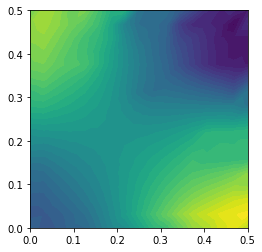

In [15]:
plot(psi_on[0][0])

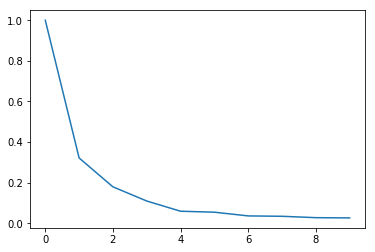

In [32]:
plt.plot(w[::-1]/w[-1])

In [38]:
list(map(lambda x: x.compute_vertex_values(), psi_snap))

[array([  1.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   3.46209276e-01,   1.39016597e-01,
          6.44253713e-02,   3.37876603e-02,   1.95469761e-02,
          1.21779104e-02,   8.00965407e-03,   5.47311658e-03,
          3.83194393e-03,   2.71118520e-03,   1.90573821e-03,
          1.29576591e-03,   8.06399293e-04,   3.87072659e-04,
          0.00000000e+00,   0.00000000e+00,   3.46209276e-01,
          2.45820508e-01,   1.45431739e-01,   8.48972284e-02,
          5.11782937e-02,   3.22223336e-02,   2.11550114e-02,
          1.43875893e-02,   1.00508683e-02,   7.14347394e-03,
          5.10705866e-03,   3.61600172e-03,   2.47092612e-03,
        

In [103]:
c2.vector()[c2.vector()[:] > 1]

array([   100.,    200.,    200.,    200.,    200.,    200.,    200.,
          200.,    200.,    200.,    200.,    200.,    200.,    200.,
          200.,    200.,    200.,    200.,    200.,    200.,    100.,
          200.,    200.,    100.,    200.,    200.,  20000.,    200.,
          200.,    100.,    200.,    200.,    100.,    200.,    200.,
          100.,    200.,    200.,    200.,    100.,    200.,    200.,
          200.,    100.,    200.,    200.,    100.,    200.,    200.,
          100.,    200.,    200.,    200.,    100.,    200.,    200.,
          200.,    100.,    200.,    200.,    200.,    100.,    200.,
          200.,    100.,    200.,    200.,    100.,    200.,    100.,
          200.,    100.,    200.,    100.,    200.,    200.,    100.,
          200.,    200.,    100.,    200.,    200.,    100.,    200.,
          200.,    100.,    200.,    200.,    100.,    200.,    200.,
          100.,    200.,    100.,    200.,    200.,    100.,    200.,
          200.,    1

In [92]:
cp = ColoredPartition(7, 3)

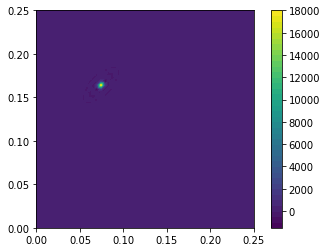

In [90]:
p = plot(c1);
plt.colorbar(p)

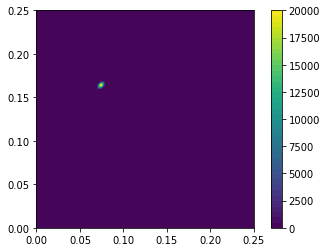

In [91]:
p = plot(c2);
plt.colorbar(p)

In [93]:
cp.partition(15)

(1, 1)

In [94]:
print((cp.map['c'] != None).sum())
print(cp.map['c'])
print()
print(cp.map['r'])

45
[[0 1 2 0 1 2 0]
 [0 1 2 0 1 2 1]
 [0 1 2 0 1 2 2]
 [0 1 2 0 1 2 None]
 [0 1 2 0 1 2 None]
 [0 1 2 0 1 2 None]
 [0 1 2 0 1 2 None]]

[[0 0 0 7 7 7 14]
 [1 1 1 8 8 8 14]
 [2 2 2 9 9 9 14]
 [3 3 3 10 10 10 None]
 [4 4 4 11 11 11 None]
 [5 5 5 12 12 12 None]
 [6 6 6 13 13 13 None]]


In [110]:
x = np.random.rand(3, 4)

array([ 0.70210437,  0.96569764,  0.09050988,  0.05812514,  0.58801742,
        0.75117376,  0.51131739,  0.92050119,  0.3039641 ,  0.49300273,
        0.97936034,  0.32350827])

In [101]:
ms_solver[None] = 'k'

In [105]:
ms_solver

{0: <mpi_gmsfem.SpaceBlocks at 0x7feb366f85c0>,
 7: <mpi_gmsfem.SpaceBlocks at 0x7feb366f8b70>,
 14: <mpi_gmsfem.SpaceBlocks at 0x7feb366f8fd0>}

In [8]:
tmp = cp.cid + cp.countMSGTransfers(transferOverMSG=True)
np.repeat(tmp, cp.dimC)


array([4, 4, 4, 4, 4, 3, 3, 3, 3, 3], dtype=int8)

In [100]:
from mpi4py import MPI as mpi

In [111]:
cdist = np.array([4, 0, 0, 0, 3, 0])

In [112]:
hist = np.full((cdist.max(), len(cdist)), False)
for i,v in enumerate(cdist):
    hist[:v, i] = 1

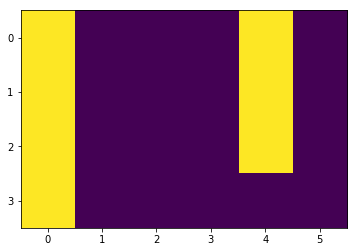

In [113]:
plt.imshow(hist)
plt.yticks([0, 1, 2, 3]);

In [135]:
i = 0
x_bot,*_ = np.where(hist[i] == 0)
x_top,*_ = np.where(hist[-i-1] == 1)

In [152]:
parcel_volume = np.zeros_like(cdist)
addressee = [[] for _ in range(len(cdist))]
addresser = [[] for _ in range(len(cdist))]

In [149]:
addresser[x_bot]

[]

In [153]:
parcel_volume[x_top] += 1
parcel_volume

array([1, 0, 0, 0, 0, 0])

In [136]:
x_bot[:len(x_top)]

array([1])

In [101]:
x

array([1, 2, 3, 5])

[1 2 3 5]


In [ ]:
for i in range(len(hist)):
    hist[i] = 
    hist[-(i+1)]

In [70]:
K_prod = Function(V)
K_prod.vector()[:] = K[0].vector().get_local() * K[1].vector().get_local()

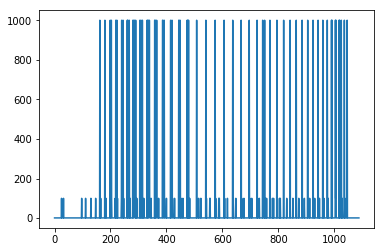

In [71]:
k0 = K[0].vector().get_local()
k1 = K[1].vector().get_local()

plt.plot(k0*k1)

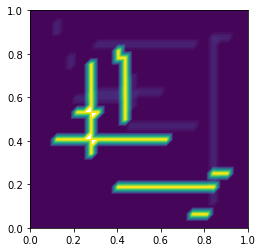

In [73]:
plot(K_prod);

In [46]:
res = project(res, V)

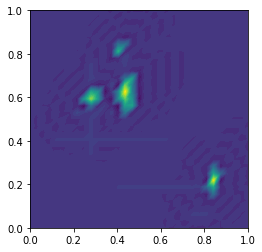

In [47]:
plot(res);

In [ ]:
fig = plt.figure()
for i in range(len(psi_snap)):
    plot(psi_snap[1]);
    fig.canvas.flush_events();

In [1]:
# MINIMAL WORKING EXAMPLE
import time
import numpy as np

from ufl import *
from dolfin import *

N = 32
M = 4*N
mesh = UnitSquareMesh(N, N)
V = FunctionSpace(mesh, 'P', 1)

Psi_array = []
kappa = Function(V)
kappa.vector()[:] = 1.

# Create simple functions for easier debugging
# In this case, Mass_matrix_ij = i*j
#               Stiffness_matrix_ij = 0
for i in range(M):
    psi = Function(V)
    psi.vector()[:] = i
    Psi_array.append(psi)
    
Mass_matrix = np.empty((M, M))
elapsed_time =- time.time()
#----
for i in range(M):
    for j in range(i, M):
        Mass_matrix[i, j] = assemble(kappa*Psi_array[i]*Psi_array[j]*dx)
#----
elapsed_time += time.time()
print(f'Calculating mass matrix has taken {elapsed_time:.2f} s')

# Don't take into account transpose operation
ij_lower = np.tril_indices(M, -1)
Mass_matrix[ij_lower] = Mass_matrix.T[ij_lower]

Stiffness_matrix = np.empty((M, M))
elapsed_time =- time.time()
#----
for i in range(M):
    for j in range(i, M):
        Stiffness_matrix[i, j] = assemble(
            kappa*dot(grad(Psi_array[i]), grad(Psi_array[j]))*dx)
#----
elapsed_time += time.time()
print(f'Calculating stiffness matrix has taken {elapsed_time:.2f} s')

# Don't take into account transpose operation
ij_lower = np.tril_indices(M, -1)
Stiffness_matrix[ij_lower] = Stiffness_matrix.T[ij_lower]

Calculating mass matrix has taken 15.98 s
Calculating stiffness matrix has taken 14.66 s


In [ ]:
np.empty()

In [59]:
import numpy as np
import scipy.linalg as NLA # num. lin. algebra

M = 4*512
R1 = np.random.rand(M, M)
R2 = np.random.rand(M, M)

Mass_matrix = R1@R2.T
Stiffness_matrix = R2@R2.T

# select 10 dominant eigenvalues
w, v = NLA.eigh(Mass_matrix, Stiffness_matrix)#, eigvals=(M-10, M-1))

In [58]:
w.shape

(256,)

In [39]:
Mass_matrix

array([[ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  2.,  3.,  4.],
       [ 0.,  2.,  4.,  6.,  8.],
       [ 0.,  3.,  6.,  9., 12.],
       [ 0.,  4.,  8., 12., 16.]])

In [40]:
elapsed_time

0.03634810447692871

In [41]:
Stiffness_matrix

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])